## Recreating Smoothed Collocation in Python based on Julia libraries
based on - https://docs.sciml.ai/DiffEqFlux/stable/examples/collocation/

In [276]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.linalg import solve, LinAlgError, det

`Initial Simplified Attempt`

In [277]:
def true_ode_func(t, u):
    true_A = np.array([[-0.1, 2.0], [-2.0, -0.1]])
    return true_A.dot(u**3)

u0 = np.array([2.0, 0.0], dtype=np.float32)
tspan = (0.0, 1.5)
tsteps = np.linspace(*tspan, num=300)
print(tsteps.shape)

sol = solve_ivp(true_ode_func, tspan, u0, t_eval=tsteps, method='RK45')
print(sol)
true_data = sol.y

# NOISY DATA
data = sol.y + 0.1 * np.random.randn(*sol.y.shape)
print(data.shape)
print(data)

(300,)
  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.017e-03 ...  1.495e+00  1.500e+00]
        y: [[ 2.000e+00  1.996e+00 ...  1.303e+00  1.293e+00]
            [ 0.000e+00 -8.003e-02 ... -9.487e-01 -9.702e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 128
     njev: 0
      nlu: 0
(2, 300)
[[ 1.98600186  1.95696237  1.96389394  1.94727036  1.95367479  1.97594408
   2.00041029  2.0068417   1.9281744   2.07847168  1.83896863  1.92194266
   1.87825303  1.85551087  1.81546551  1.77761052  1.73974297  1.71618042
   1.9272387   1.8301922   1.86013835  1.63257798  1.66571652  1.57118214
   1.51487221  1.48607182  1.5423878   1.60485112  1.35614415  1.70889999
   1.27888365  1.33688901  1.12346805  1.15544181  0.98418246  0.86845625
   0.93522346  0.77012916  0.73618806  0.80820319  0.50632812  0.70862285
   0.48904006  0.39422851  0.47466407  0.62859053  0.34327143  0.23234769
   0.142

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


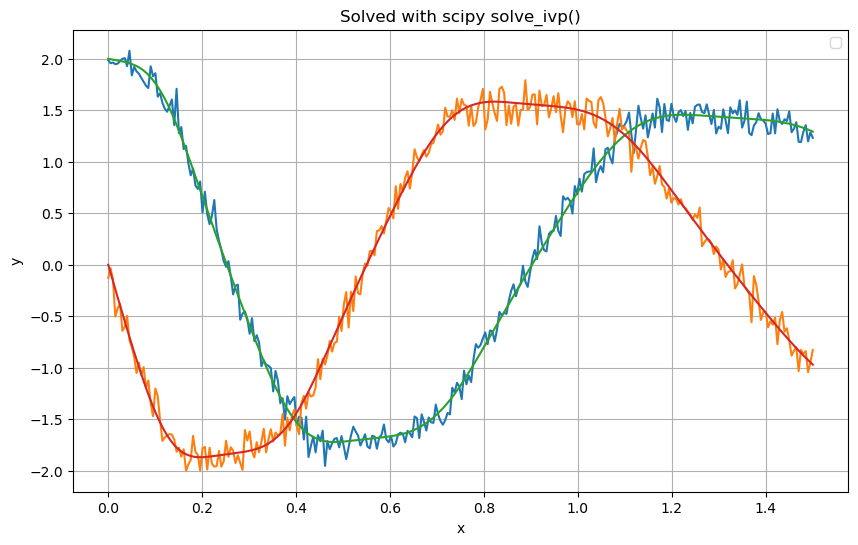

In [278]:
plt.figure(figsize=(10, 6))
plt.plot(tsteps, data[0])
plt.plot(tsteps, data[1])
plt.plot(tsteps, true_data[0])
plt.plot(tsteps, true_data[1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solved with scipy solve_ivp()')
plt.legend()
plt.grid(True)
plt.show()

In [279]:
# define kernels
def calckernel(kernel, t):
    abst = abs(t)
    if abst > 1:
        return 0
    return kernel_dict[kernel](t, abst)

def triangular_kernel(t, abst):
    return 1 - abst

def epanechnikov_kernel(t, abst):
    return 0.75 * (1 - t**2)

kernel_dict = {
    'EpanechnikovKernel': epanechnikov_kernel,
    'TriangularKernel': triangular_kernel,
}

In [280]:
def collocate_data(data, tpoints, kernel='EpanechnikovKernel', bandwidth=None):
    n = len(tpoints)
    
#------------------------------------BANDWIDTH-----------------------------------#
    if bandwidth is None:
        bandwidth = n**(-1/5) * n**(-3/35) * (np.log(n))**(-1/16)
        print('Bandwidth:', bandwidth)

    estimated_solution = np.zeros_like(data)
    data = data.T

    for i, t in enumerate(tpoints):
#--------------------------------KERNEL WEIGHTS--------------------------------#
        # computes the weights for each point in tpoints
        weights = np.array([calckernel(kernel, (tp - t) / bandwidth) for tp in tpoints])
        W = np.diag(weights)

#----------------------------------CONSTRUCT MATRIX----------------------------#
        # second column is the differences between target points and the current point
        A = np.vstack([np.ones_like(tpoints), tpoints - t]).T
        
#------------------------APPLY WEIGHTS TO THE MATRIX---------------------------#
        A_weighted = W @ A
        
        # iterate over each variable
        for var in range(data.shape[1]):
            # weighted target vector for the current variable
            b = W @ data[:, var]
            # Before solving the linear system, this check ensures that the matrix A_weighted is not singular 
            if np.linalg.matrix_rank(A_weighted) < A_weighted.shape[1]:
                continue  # skip if A_weighted is singular
            # solve the Weighted Least Squares Problem
            solution = solve(A_weighted.T @ A_weighted, A_weighted.T @ b) # (A^T * W * A)^-1 * A^T * W * b
            # stores the intercept (the constant term of the regression model) in the output matrix
            estimated_solution[var, i] = solution[0] 

    return estimated_solution  

`implementation`
* fit a linear model to each variable, using weights to adjust for the importance or relevance of each data point

In [281]:
#-------------------------------------NODE SET UP----------------------------------#
#-----------------------------------DATA GENERATION--------------------------------#
#------------------------------------COLLOCATION MATRIX----------------------------#
#-----------------------------------MODEL CREATION---------------------------------#
#---------------------------------NEURAL NET PARAMS--------------------------------#
#-----------------------------------FORWARD PASS-----------------------------------#
#--------------------------------INITIAL CONDITIONS--------------------------------#
#------------------------------------CONSTRAINTS-----------------------------------#
#-----------------------------OBJECTIVE FUNCTION DEFINITION------------------------#
#--------------------------------SOLVING THE MODEL---------------------------------#


In [282]:
import jax
import jax.numpy as jnp
from jax.scipy.linalg import solve
from jax.experimental.ode import odeint

In [283]:
#-----------------------------------TRUE ODE--------------------------------#

def true_ode_func(u, t, true_A):
    return true_A.dot(u**3)

#-----------------------------------DATA GENERATION--------------------------------#

u0 = jnp.array([2.0, 0.0], dtype=jnp.float32)
tspan = (0.0, 1.5)
tsteps = jnp.linspace(*tspan, num=300)

print(tsteps.shape)

# Define the true_A matrix
true_A = jnp.array([[-0.1, 2.0], [-2.0, -0.1]], dtype=jnp.float32)

sol = odeint(true_ode_func, u0, tsteps, true_A)

# print(sol)
true_data = sol

#-----------------------------------NOISE--------------------------------#
key = jax.random.PRNGKey(0)
noise = 0.1 * jax.random.normal(key, shape=sol.shape)
data = sol + noise

print(data.shape)
# print(data)

(300,)
(300, 2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


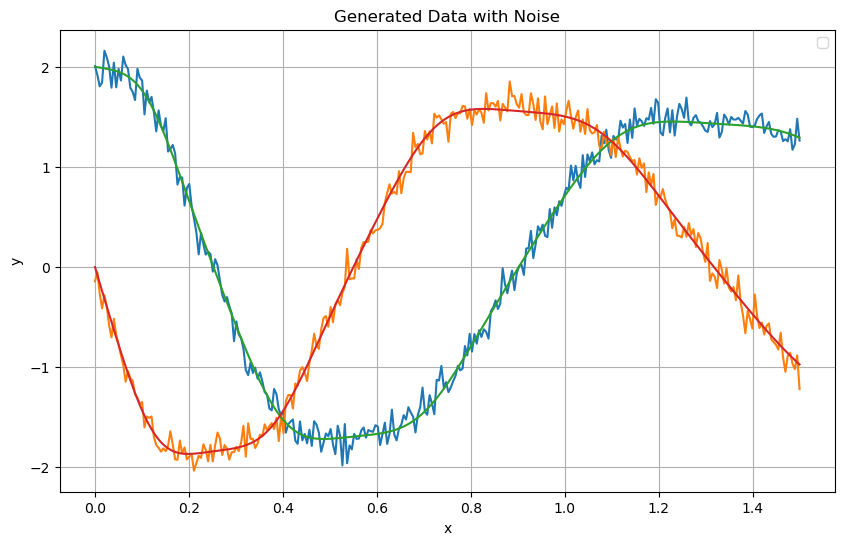

In [284]:
plt.figure(figsize=(10, 6))
plt.plot(tsteps, data.T[0])
plt.plot(tsteps, data.T[1])
plt.plot(tsteps, true_data.T[0])
plt.plot(tsteps, true_data.T[1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Generated Data with Noise')
plt.legend()
plt.grid(True)
plt.show()

In [285]:
#-----------------------------------COLLOCATION FUNCTIONS--------------------------------#

def construct_t_matrix(order, tpoints, t):
    """
    Constructs the T matrix for collocation.

    Args:
        order (int): The order of the T matrix (1 or 2).
        tpoints (jax.numpy.ndarray): The array of time points.
        t (float): The current time point.

    Returns:
        jax.numpy.ndarray: The constructed T matrix.
    """
    if order == 1:
        return jnp.vstack([jnp.ones_like(tpoints), tpoints - t]).T
    elif order == 2:
        return jnp.vstack([jnp.ones_like(tpoints), tpoints - t, (tpoints - t)**2]).T

def construct_w(tpoints, t, bandwidth, kernel_type):
    """
    Constructs the weight matrix W for collocation.

    Args:
        tpoints (jax.numpy.ndarray): The array of time points.
        t (float): The current time point.
        bandwidth (float): The bandwidth for the kernel.
        kernel_type (str): The type of kernel to use ("TriangularKernel" or "EpanechnikovKernel").

    Returns:
        jax.numpy.ndarray: The diagonal weight matrix W.
    """
    return jnp.diag(jax.vmap(lambda tp: calckernel(kernel_type, (tp - t) / bandwidth))(tpoints))

def calckernel(kernel_type, x):
    """
    Calculates the kernel value.

    Args:
        kernel_type (str): The type of kernel to use ("TriangularKernel" or "EpanechnikovKernel").
        x (float): The input value for the kernel function.

    Returns:
        float: The calculated kernel value.
    """
    if kernel_type == "TriangularKernel":
        return jnp.maximum((1 - jnp.abs(x)), 0)
    elif kernel_type == "EpanechnikovKernel":
        return (3/4) * jnp.maximum((1 - x**2), 0)
    
def configure_extraction_vectors(data):
    """
    Configures the extraction vectors e1 and e2.

    Args:
        data (jax.numpy.ndarray): The data array to infer the shape.

    Returns:
        tuple: The extraction vectors e1 and e2.
    """
    _one = 1.0
    _zero = 0.0

    # To extract the constant term (intercept)
    e1 = jnp.array([[_one, _zero]]).T  
    # To extract the linear term and optionally the quadratic term
    e2 = jnp.array([[_zero, _one, _zero]]).T 
    
    return e1, e2

In [286]:
from jax.numpy.linalg import solve, inv

In [271]:
def collocate_data(data, tpoints, kernel="TriangularKernel", bandwidth=None):
    """
    Applies the kernel-based collocation method to smooth data.

    Args:
        data (jax.numpy.ndarray): The noisy data array.
        tpoints (jax.numpy.ndarray): The array of time points.
        kernel (str, optional): The type of kernel to use. Defaults to "TriangularKernel".
        bandwidth (float, optional): The bandwidth for the kernel. If None, it is calculated automatically. Defaults to None.

    Returns:
        tuple: The estimated derivatives and smoothed solutions.
    """
    n = len(tpoints)

#-----------------------------------BANDWIDTH----------------------------------#
    if bandwidth is None:
        bandwidth = (n**(-1/5)) * (n**(-3/35)) * (jnp.log(n)**(-1/16))
    
    # M = construct_t_matrix(2, tpoints, 0)

#-------------------------COEFFICIENT EXTRACTION VECTORS------------------------#
    # later on used to extract  coefficients from local polynomial approximations
    e1, e2 = configure_extraction_vectors(data)

    # print(e2.shape)
    estimated_solution = []
    estimated_derivative = []

    for _t in tpoints:
#-----------------------------MATRIX CONSTRUCTION--------------------------------#
        # constructs the first-order T matrix
        T1 = construct_t_matrix(1, tpoints, _t)
        # constructs the second-order T matrix
        T2 = construct_t_matrix(2, tpoints, _t)
        # constructs the weight matrix
        W = construct_w(tpoints, _t, bandwidth, kernel)
        # print(W)
#-----------------------------------WEIGHT DATA-----------------------------------#
        # print(W.shape)
        # print(data.shape)
        Wd = W @ data.T

#---------------------------------WEIGHT T-MATRICES-------------------------------#
        WT1 = W @ T1
        WT2 = W @ T2
        
        # form matrices for the least-squares weighted quadratic fitting problem
        T1WT1 = T1.T @ WT1
        T2WT2 = T2.T @ WT2
#---------------------------------------------------------------------------------#
#                           Solve (T1^T W T1 c1) = T1^T W y 
#---------------------------------------------------------------------------------#

#-----------------------------------INVERSE--------------------------------------#
        # inv_T1WT1 = jnp.linalg.inv(T1WT1)
        # inv_T2WT2 = jnp.linalg.inv(T2WT2)

#------------------------------EXTRACT COEFFICIENTS------------------------------#
        """ 
        Solution through matrix inversion,
        but somet
        inv_T1WT1 = inv(T1WT1)
        solution1 = inv_T1WT1 @ (T1.T @ Wd)
        result_solution = e1.T @ solution1
        estimated_solution.append(result_solution)
        
       
        inv_T2WT2 = inv(T2WT2)
        solution2 = inv_T2WT2 @ (T2.T @ Wd)
        result_derivative = e2.T @ solution2
        estimated_derivative.append(result_derivative)
        
        estimated_solution_stacked = jnp.stack(estimated_solution).T
        estimated_derivative_stacked = jnp.stack(estimated_derivative).T

    return estimated_solution_stacked, estimated_derivative_stacked"""

        solution1 = solve(T1WT1, T1.T @ Wd)
        result_solution = e1.T @ solution1
        estimated_solution.append(result_solution)
        
        solution2 = solve(T2WT2, T2.T @ Wd)
        result_derivative = e2.T @ solution2
        estimated_derivative.append(result_derivative)
        
        estimated_solution_ = jnp.stack(estimated_solution).T
        estimated_derivative_ = jnp.stack(estimated_derivative).T

    return estimated_derivative_, estimated_solution_
    

'        print(f"inv_T1WT1: {inv_T1WT1.shape}")\n        print(f"T1.T: {T1.T.shape}")\n        print(f"WT1: {WT1.shape}")\n        print(f"Wd: {Wd.shape}")   \n        temp_solution = inv_T1WT1 @ (T1.T @ WT1 @ Wd.T)\n        estimated_solution.append(e1.T @ temp_solution)\n\n        inv_T2WT2 = jnp.linalg.inv(T2WT2)\n        \n        print(f"inv_T2WT2: {inv_T2WT2.shape}")\n        print(f"T2.T: {T2.T.shape}")\n        print(f"WT2: {WT2.shape}")\n        print(f"Wd: {Wd.shape}")\n        #\xa0temp_derivative = inv_T2WT2 @ (T2.T @ WT2 @ Wd.T)\n        # print(temp_derivative.shape)\n        return 0\n        estimated_derivative.append(e2 @ temp_derivative)\n\n    return jnp.hstack(estimated_derivative).T, jnp.hstack(estimated_solution).T'

In [272]:
data0 = jnp.expand_dims(data.T[0], axis=0)

In [273]:
collocate_data(data0, tsteps, kernel="TriangularKernel", bandwidth=None)

(Array([[[  2.8905592 ,   2.5336642 ,   2.1502337 ,   1.7017802 ,
            1.2614396 ,   0.7999712 ,   0.30541417,  -0.18561697,
           -0.67353654,  -1.1484919 ,  -1.6095835 ,  -2.0880308 ,
           -2.573191  ,  -3.060565  ,  -3.5498815 ,  -4.036063  ,
           -4.5110083 ,  -4.977427  ,  -5.4311113 ,  -5.871582  ,
           -6.2963424 ,  -6.7053046 ,  -7.096231  ,  -7.4710026 ,
           -7.8290033 ,  -8.174004  ,  -8.502038  ,  -8.814307  ,
           -9.1114645 ,  -9.394568  ,  -9.667782  ,  -9.931371  ,
          -10.181149  , -10.419289  , -10.6442795 , -10.859392  ,
          -11.056703  , -11.234733  , -11.391489  , -11.527165  ,
          -11.652821  , -11.765807  , -11.856861  , -11.921075  ,
          -11.968603  , -11.99471   , -12.003376  , -11.996709  ,
          -11.978708  , -11.946983  , -11.900387  , -11.839775  ,
          -11.764422  , -11.666345  , -11.559166  , -11.440302  ,
          -11.312474  , -11.164271  , -11.0066595 , -10.831621  ,
          

In [274]:
#-----------------------------------APPLYING COLLOCATION--------------------------------#

estimated_derivative, estimated_solution = collocate_data(data0, tsteps, kernel="TriangularKernel", bandwidth=None)

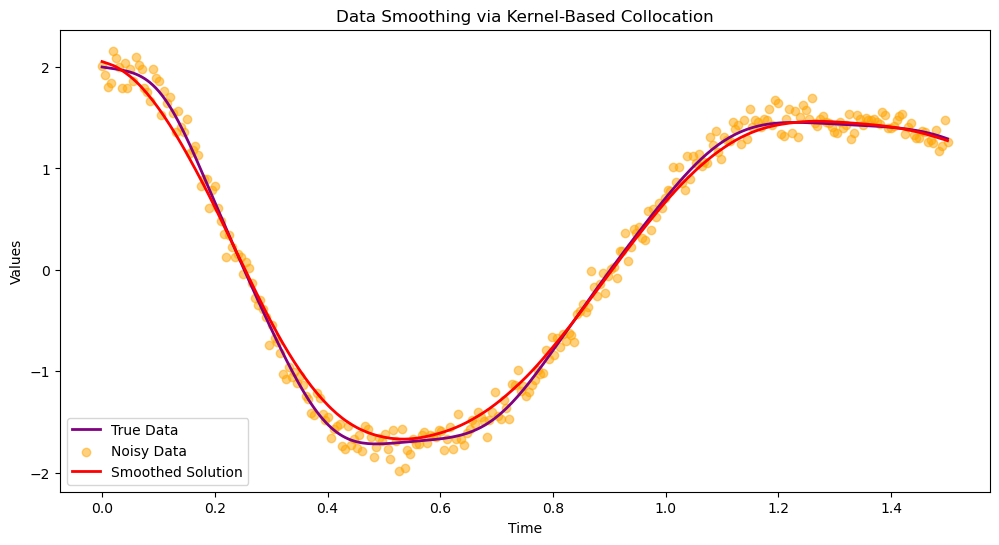

In [275]:
#-----------------------------------PLOTTING RESULTS--------------------------------#

plt.figure(figsize=(12, 6))
plt.plot(tsteps, true_data[:, 0], 'purple', linewidth=2, label='True Data')
plt.scatter(tsteps, data[:, 0], color='orange', alpha=0.5, label='Noisy Data')
plt.plot(tsteps, estimated_solution[0][0], 'r-', linewidth=2, label='Smoothed Solution')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Data Smoothing via Kernel-Based Collocation')
plt.legend()
plt.show()

In [29]:
print(data.shape)
data[0].shape
print(tsteps.shape)

(2, 300)
(300,)


In [19]:
estimated_solution = collocate_data(data, tsteps)

TypeError: dot_general requires contracting dimensions to have the same shape, got (2,) and (3,).

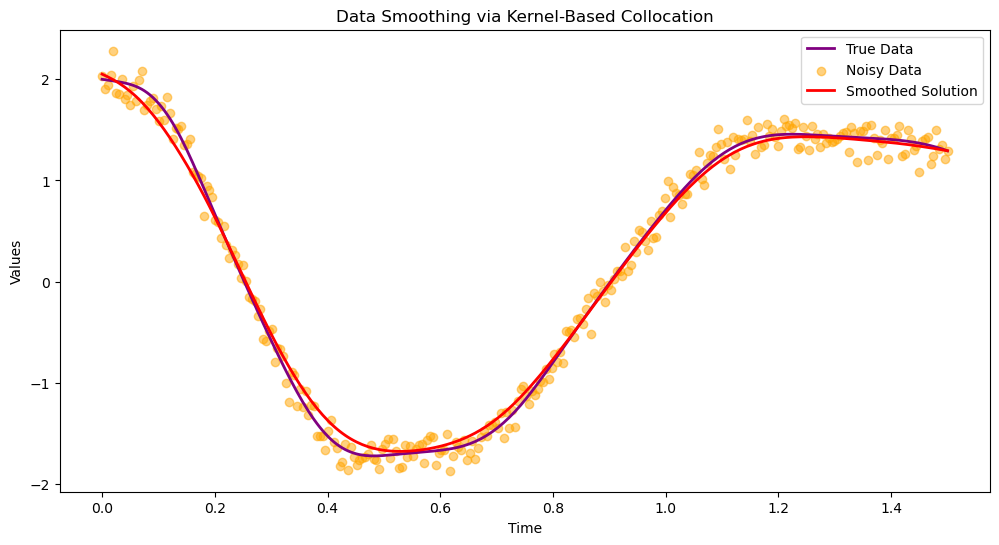

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(tsteps, true_data[0], 'purple', linewidth=2, label='True Data')
plt.scatter(tsteps, data[0], color='orange', alpha=0.5, label='Noisy Data')
plt.plot(tsteps, estimated_solution[0], 'r-', linewidth=2, label='Smoothed Solution')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Data Smoothing via Kernel-Based Collocation')
plt.legend()
plt.show()

### How would this look if just regular interpolation was used?

In [ ]:
# fit cspline to data
spline = CubicSpline(t, data)
# generate collocation points
collocation_t = np.linspace(t[0], t[-1], num_points)
# evaluate spline at collocation points
collocation_data = spline(collocation_t)
# evaluate derivative of spline at coll. pts
collocation_derivative = spline(collocation_t, 1)

## Damped Oscillation

In [34]:
from interpolation import BarycentricInterpolation

In [43]:
def odes(t, y):
    X, Y = y
    dXdt = -0.1 * X**3 - 2 * Y**3
    dYdt = 2 * X**3 - 0.1 * Y**3
    return [dXdt, dYdt]


u0 = [1.0, 1.0]  
tspan = (0, 10) 
tsteps = np.linspace(*tspan, 500) 
# tsteps = interpolator.nodes

sol = solve_ivp(odes, tspan, u0, t_eval=tsteps, method='RK45')
true_data = sol.y

# noisy
noisy_data = true_data + 0.1 * np.random.randn(*true_data.shape)

## Equally Spaced Points

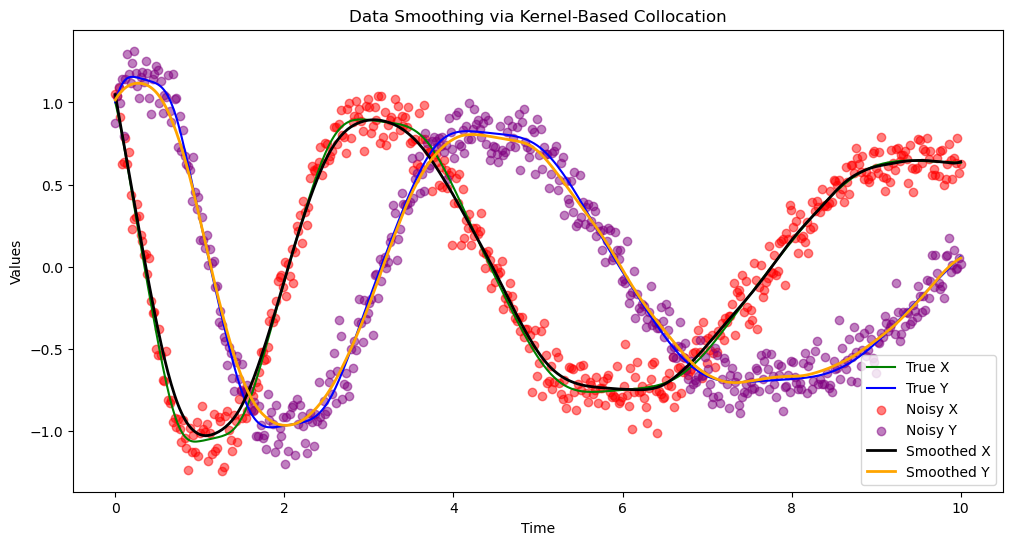

In [44]:
smoothed_data = collocate_data(noisy_data, tsteps, kernel='EpanechnikovKernel', bandwidth=0.5)

plt.figure(figsize=(12, 6))

plt.plot(tsteps, true_data[0], 'g-', label='True X')
plt.plot(tsteps, true_data[1], 'b-', label='True Y')

plt.scatter(tsteps, noisy_data[0], color='red', alpha=0.5, label='Noisy X')
plt.scatter(tsteps, noisy_data[1], color='purple', alpha=0.5, label='Noisy Y')

plt.plot(tsteps, smoothed_data[0], 'k-', label='Smoothed X', linewidth=2)
plt.plot(tsteps, smoothed_data[1], 'orange', label='Smoothed Y', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Data Smoothing via Kernel-Based Collocation')
plt.legend()
plt.show()

## Chebyshev Nodes

In [ ]:
def odes(t, y):
    X, Y = y
    dXdt = -0.1 * X**3 - 2 * Y**3
    dYdt = 2 * X**3 - 0.1 * Y**3
    return [dXdt, dYdt]


u0 = [1.0, 1.0]  
tspan = (0, 10) 
# tsteps = np.linspace(*tspan, 500) 

interpolator = BarycentricInterpolation(500, 0, 10)
tsteps = interpolator.nodes

sol = solve_ivp(odes, tspan, u0, t_eval=tsteps, method='RK45')
true_data = sol.y

# noisy
noisy_data = true_data + 0.1 * np.random.randn(*true_data.shape)

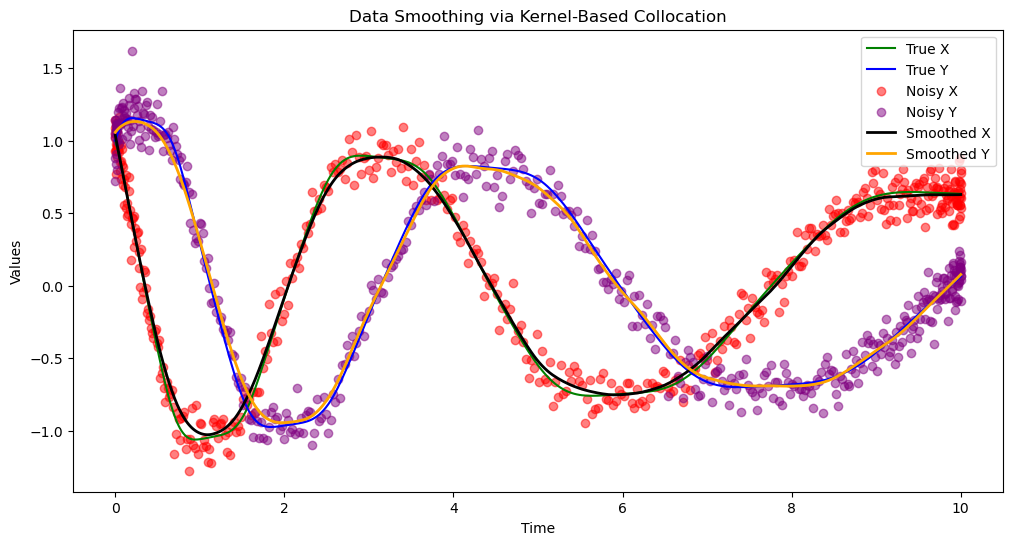

In [41]:
smoothed_data = collocate_data(noisy_data, tsteps, kernel='EpanechnikovKernel', bandwidth=0.5)

plt.figure(figsize=(12, 6))

plt.plot(tsteps, true_data[0], 'g-', label='True X')
plt.plot(tsteps, true_data[1], 'b-', label='True Y')

plt.scatter(tsteps, noisy_data[0], color='red', alpha=0.5, label='Noisy X')
plt.scatter(tsteps, noisy_data[1], color='purple', alpha=0.5, label='Noisy Y')

plt.plot(tsteps, smoothed_data[0], 'k-', label='Smoothed X', linewidth=2)
plt.plot(tsteps, smoothed_data[1], 'orange', label='Smoothed Y', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Data Smoothing via Kernel-Based Collocation')
plt.legend()
plt.show()